In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-transaction-dataset/products.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

1. надо добавить красивых графиков

# Data loading, EDA & Data Preporasion

In [3]:
df = pd.read_csv('/kaggle/input/retail-transaction-dataset/products.csv')

In [4]:
df.head()

,TransactionID,CustomerID,Products,Timestamp
0,1,C546,"Dish Sponge, Flatbread with Meat, Chips, Orang...",2025-02-18
1,2,C385,"Onion, Juice, Flatbread with Meat, Chicken",2025-04-26
2,3,C292,"Egg, Flatbread with Meat, Banana, Pizza",2025-04-25
3,4,C863,"Ice Cream, Soda, Orange, Potato, Cereal, Choco...",2025-01-14
4,5,C171,"Ice Cream, Soap, Shampoo, Chicken, Banana, Bea...",2025-04-20


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  30000 non-null  int64 
 1   CustomerID     30000 non-null  object
 2   Products       30000 non-null  object
 3   Timestamp      30000 non-null  object
dtypes: int64(1), object(3)
memory usage: 937.6+ KB


In [6]:
df.duplicated().sum()

0

In [7]:
for c in ['TransactionID', 'CustomerID', 'Products', 'Timestamp']:
    print(df[c].nunique())

30000
1000
29889
120


* 30,000 unique transactions: no duplicates
* 1,000 customers: an average of ~30 purchases per customer
* 29,889 unique shopping carts: almost all different, high variability
* 120 unique dates: the period covers approximately 4 months in 2025

In [8]:
df.groupby('CustomerID')['TransactionID'].count().describe()

count    1000.000000
mean       30.000000
std         5.714775
min        14.000000
25%        26.000000
50%        30.000000
75%        33.000000
max        52.000000
Name: TransactionID, dtype: float64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


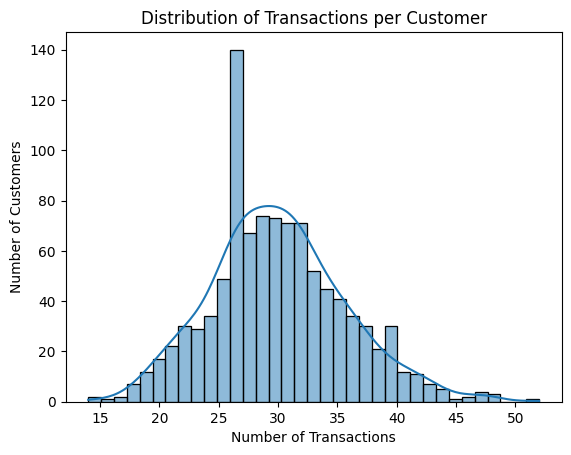

In [9]:
sns.histplot(df.groupby('CustomerID')['TransactionID'].count(), kde=True, bins=35, edgecolor='black')
plt.title('Distribution of Transactions per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')
plt.show()

In [10]:
df.groupby('CustomerID')['TransactionID'].count()

CustomerID
C1       34
C10      31
C100     30
C1000    31
C101     42
         ..
C995     25
C996     15
C997     26
C998     28
C999     43
Name: TransactionID, Length: 1000, dtype: int64

In [11]:
order_counts = df.groupby('CustomerID')['TransactionID'].count()
order_counts.value_counts().sort_index()

TransactionID
14     1
15     1
16     1
17     2
18     7
19    12
20    17
21    22
22    30
23    29
24    34
25    49
26    61
27    79
28    67
29    74
30    73
31    71
32    71
33    52
34    45
35    41
36    34
37    30
38    21
39    16
40    14
41    12
42    11
43     7
44     5
45     1
46     2
47     4
48     3
52     1
Name: count, dtype: int64

In [12]:
print(df['Timestamp'].min())
print(df['Timestamp'].max())

2025-01-01
2025-04-30


In [13]:
df['Products'].apply(lambda x: len(x.split(','))).describe()

count    30000.000000
mean         6.583633
std          2.332464
min          3.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         11.000000
Name: Products, dtype: float64

In [14]:
duplicated = df.Products[df['Products'].duplicated()]

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(duplicated)

856                         Fish, Juice, Lentil
3496                   Milk, Juice, Dish Sponge
3888                    Lentil, Pizza, Cucumber
5330                     Pizza, Fish, Chickpeas
6743                  Sausage, Honey, Ice Cream
6804                         Cereal, Honey, Egg
7663                        Lentil, Fish, Honey
7965               Pizza, Cucumber, Honey, Soda
8628                  Chickpeas, Bread, Cracker
9441                 Beans, Soap, Water, Lentil
9515           Soda, Dish Sponge, Potato, Water
10225         Pizza, Flatbread with Meat, Onion
10354        Tomato, Pizza, Flatbread with Meat
10432        Chickpeas, Dish Sponge, Strawberry
10831                     Tomato, Cereal, Pizza
10866                       Onion, Cracker, Egg
10884                       Onion, Cola, Tomato
11002                    Sausage, Chips, Yogurt
11043                      Pizza, Butter, Chips
11202                    Fish, Chicken, Sausage
11559                  Soda, Minced Meat

In [16]:
df['Product_list'] = df['Products'].apply(lambda x: [p.strip() for p in x.split(',')])

In [17]:
df.head()

,TransactionID,CustomerID,Products,Timestamp,Product_list
0,1,C546,"Dish Sponge, Flatbread with Meat, Chips, Orang...",2025-02-18,"[Dish Sponge, Flatbread with Meat, Chips, Oran..."
1,2,C385,"Onion, Juice, Flatbread with Meat, Chicken",2025-04-26,"[Onion, Juice, Flatbread with Meat, Chicken]"
2,3,C292,"Egg, Flatbread with Meat, Banana, Pizza",2025-04-25,"[Egg, Flatbread with Meat, Banana, Pizza]"
3,4,C863,"Ice Cream, Soda, Orange, Potato, Cereal, Choco...",2025-01-14,"[Ice Cream, Soda, Orange, Potato, Cereal, Choc..."
4,5,C171,"Ice Cream, Soap, Shampoo, Chicken, Banana, Bea...",2025-04-20,"[Ice Cream, Soap, Shampoo, Chicken, Banana, Be..."


In [18]:
unique_products = set(chain.from_iterable(df['Product_list']))

In [19]:
len(unique_products)

40

In [20]:
unique_products

{'Apple',
 'Banana',
 'Beans',
 'Bread',
 'Butter',
 'Cereal',
 'Cheese',
 'Chicken',
 'Chickpeas',
 'Chips',
 'Chocolate',
 'Cola',
 'Cookie',
 'Cracker',
 'Cucumber',
 'Detergent',
 'Dish Sponge',
 'Dumpling',
 'Egg',
 'Fish',
 'Flatbread with Meat',
 'Honey',
 'Ice Cream',
 'Juice',
 'Lentil',
 'Milk',
 'Minced Meat',
 'Onion',
 'Orange',
 'Pizza',
 'Potato',
 'Rice',
 'Sausage',
 'Shampoo',
 'Soap',
 'Soda',
 'Strawberry',
 'Tomato',
 'Water',
 'Yogurt'}

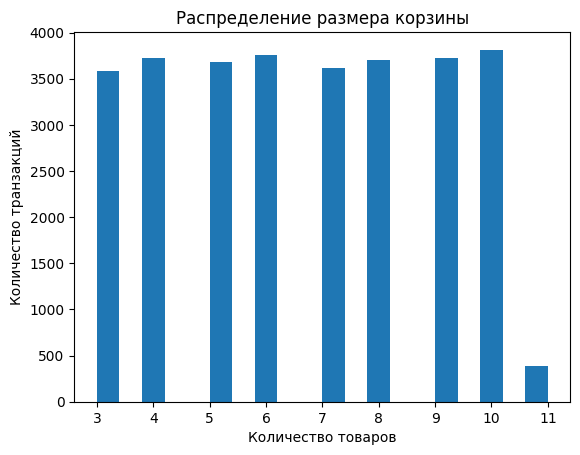

In [21]:
plt.hist(df['Products'].apply(lambda x: len(x.split(','))), bins=20)
plt.title('Распределение размера корзины')
plt.xlabel('Количество товаров')
plt.ylabel('Количество транзакций')
plt.show()

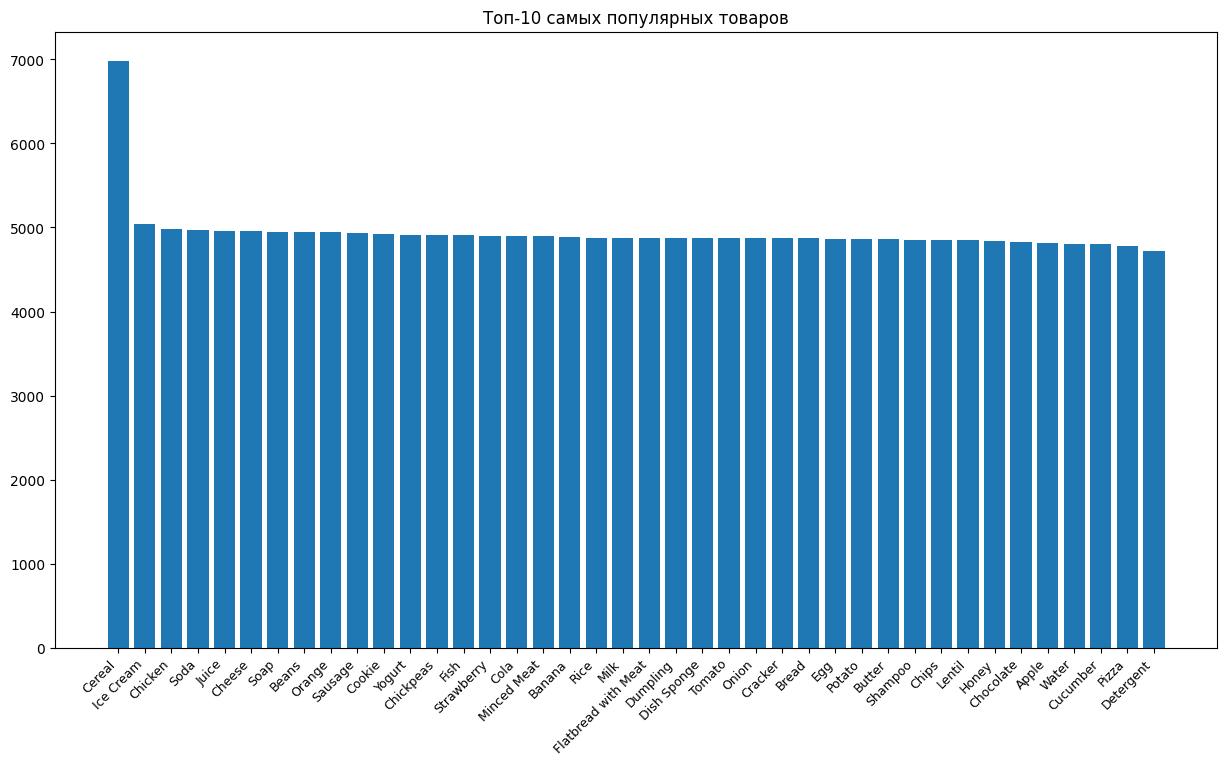

In [22]:
from collections import Counter

all_products = list(chain.from_iterable(df['Product_list']))
product_counts = Counter(all_products)
top_products = product_counts.most_common(40)

plt.figure(figsize=(15, 8))
plt.bar([p[0] for p in top_products], [p[1] for p in top_products])
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.title('Топ-10 самых популярных товаров')
plt.show()

In [23]:
df.head()

,TransactionID,CustomerID,Products,Timestamp,Product_list
0,1,C546,"Dish Sponge, Flatbread with Meat, Chips, Orang...",2025-02-18,"[Dish Sponge, Flatbread with Meat, Chips, Oran..."
1,2,C385,"Onion, Juice, Flatbread with Meat, Chicken",2025-04-26,"[Onion, Juice, Flatbread with Meat, Chicken]"
2,3,C292,"Egg, Flatbread with Meat, Banana, Pizza",2025-04-25,"[Egg, Flatbread with Meat, Banana, Pizza]"
3,4,C863,"Ice Cream, Soda, Orange, Potato, Cereal, Choco...",2025-01-14,"[Ice Cream, Soda, Orange, Potato, Cereal, Choc..."
4,5,C171,"Ice Cream, Soap, Shampoo, Chicken, Banana, Bea...",2025-04-20,"[Ice Cream, Soap, Shampoo, Chicken, Banana, Be..."


# Dataset prep

In [24]:
transactions = df['Product_list'].tolist()

In [25]:
te = TransactionEncoder()

In [26]:
te_ary = te.fit(transactions).transform(transactions)

In [27]:
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

In [28]:
basket_df.head()

,Apple,Banana,Beans,Bread,Butter,Cereal,Cheese,Chicken,Chickpeas,Chips,...,Potato,Rice,Sausage,Shampoo,Soap,Soda,Strawberry,Tomato,Water,Yogurt
0,False,False,False,False,True,False,False,False,False,True,...,False,True,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
4,False,True,True,False,False,False,True,True,False,False,...,False,False,False,True,True,False,False,False,False,False


In [29]:
basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Apple                30000 non-null  bool 
 1   Banana               30000 non-null  bool 
 2   Beans                30000 non-null  bool 
 3   Bread                30000 non-null  bool 
 4   Butter               30000 non-null  bool 
 5   Cereal               30000 non-null  bool 
 6   Cheese               30000 non-null  bool 
 7   Chicken              30000 non-null  bool 
 8   Chickpeas            30000 non-null  bool 
 9   Chips                30000 non-null  bool 
 10  Chocolate            30000 non-null  bool 
 11  Cola                 30000 non-null  bool 
 12  Cookie               30000 non-null  bool 
 13  Cracker              30000 non-null  bool 
 14  Cucumber             30000 non-null  bool 
 15  Detergent            30000 non-null  bool 
 16  Dish Sponge          3

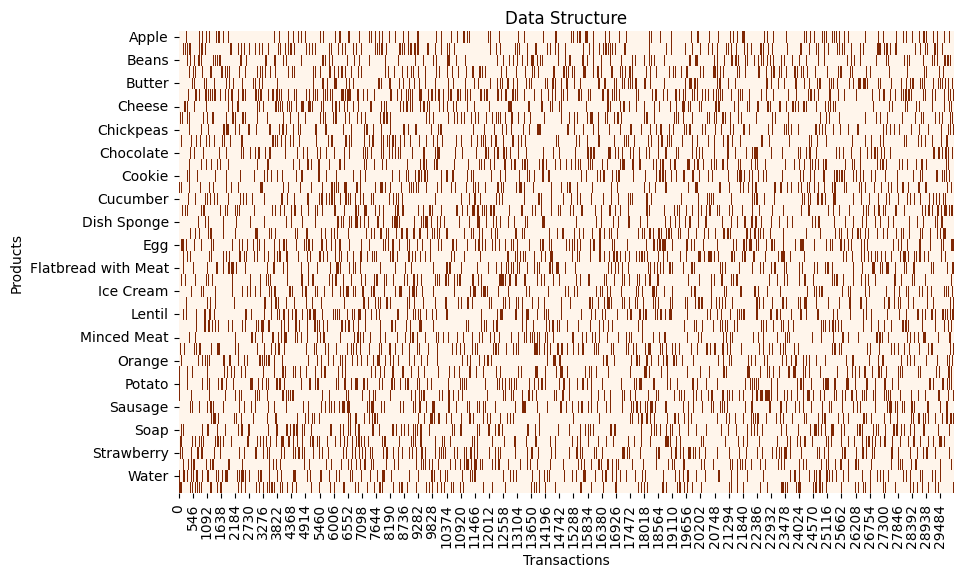

In [30]:
plt.figure(figsize=(10, 6))
sns.heatmap(basket_df.T, cmap='Oranges', cbar=False)
plt.title('Data Structure')
plt.xlabel('Transactions')
plt.ylabel('Products')
plt.show()

# Association Rules

In [31]:
freq_items = apriori(basket_df, min_support=0.005, use_colnames=True, verbose=1)

Processing 42864 combinations | Sampling itemset size 4


In [32]:
freq_items

,support,itemsets
0,0.160467,(Apple)
1,0.163033,(Banana)
2,0.164967,(Beans)
3,0.162333,(Bread)
4,0.162033,(Butter)
...,...,...
1731,0.005167,"(Sausage, Pizza, Water)"
1732,0.005067,"(Soda, Potato, Shampoo)"
1733,0.005067,"(Soap, Rice, Shampoo)"
1734,0.005167,"(Strawberry, Sausage, Water)"


In [33]:
rules = association_rules(freq_items, metric='lift', min_threshold = 1)

In [34]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Cheese),(Apple),0.165267,0.160467,0.027167,0.164381,1.024392,1.0,0.000647,1.004684,0.028526,0.090990,0.004662,0.166839
1,(Apple),(Cheese),0.160467,0.165267,0.027167,0.169298,1.024392,1.0,0.000647,1.004853,0.028363,0.090990,0.004829,0.166839
2,(Apple),(Chicken),0.160467,0.166033,0.027067,0.168675,1.015909,1.0,0.000424,1.003177,0.018653,0.090393,0.003167,0.165847
3,(Chicken),(Apple),0.166033,0.160467,0.027067,0.163019,1.015909,1.0,0.000424,1.003050,0.018777,0.090393,0.003041,0.165847
4,(Chickpeas),(Apple),0.163700,0.160467,0.028200,0.172266,1.073533,1.0,0.001932,1.014255,0.081904,0.095281,0.014055,0.174002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3657,"(Soap, Water)",(Yogurt),0.027367,0.163767,0.005033,0.183922,1.123074,1.0,0.000552,1.024698,0.112670,0.027046,0.024103,0.107328
3658,"(Yogurt, Water)",(Soap),0.027100,0.165067,0.005033,0.185732,1.125193,1.0,0.000560,1.025379,0.114363,0.026897,0.024751,0.108112
3659,(Soap),"(Yogurt, Water)",0.165067,0.027100,0.005033,0.030493,1.125193,1.0,0.000560,1.003499,0.133260,0.026897,0.003487,0.108112
3660,(Yogurt),"(Soap, Water)",0.163767,0.027367,0.005033,0.030735,1.123074,1.0,0.000552,1.003475,0.131048,0.027046,0.003463,0.107328


In [35]:
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(20)

,antecedents,consequents,support,confidence,lift
1975,(Milk),"(Cereal, Cookie)",0.016800,0.103279,2.701273
1974,"(Cereal, Cookie)",(Milk),0.016800,0.439407,2.701273
937,"(Banana, Cereal)",(Milk),0.016100,0.430865,2.648762
940,(Milk),"(Banana, Cereal)",0.016100,0.098975,2.648762
2667,(Milk),"(Cereal, Shampoo)",0.016033,0.098566,2.635443
2666,"(Cereal, Shampoo)",(Milk),0.016033,0.428699,2.635443
2686,"(Cereal, Tomato)",(Milk),0.016367,0.427328,2.627017
2687,(Milk),"(Cereal, Tomato)",0.016367,0.100615,2.627017
2311,"(Egg, Cereal)",(Milk),0.015800,0.426259,2.620445
2314,(Milk),"(Egg, Cereal)",0.015800,0.097131,2.620445


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

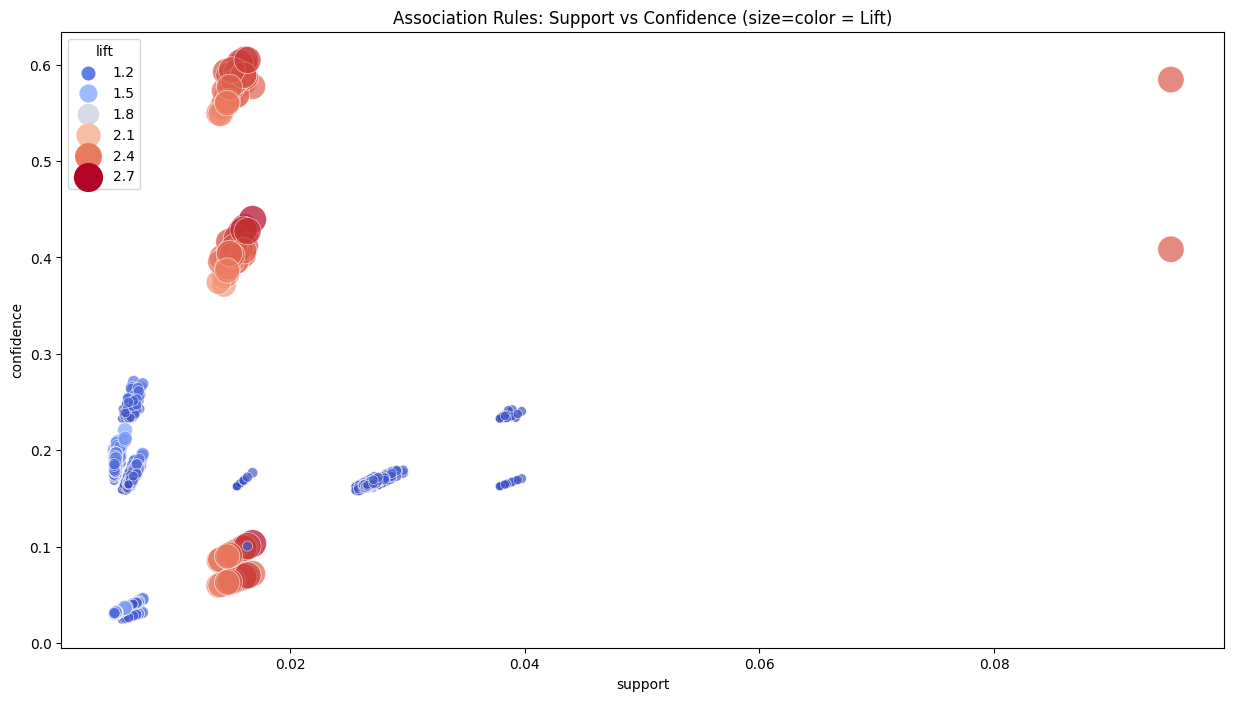

In [36]:
plt.figure(figsize=(15,8))
sns.scatterplot(
    data=rules, x='support', y='confidence',
    size='lift', hue='lift', palette='coolwarm', alpha=0.7, sizes=(40, 400)
)
plt.title('Association Rules: Support vs Confidence (size=color = Lift)')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


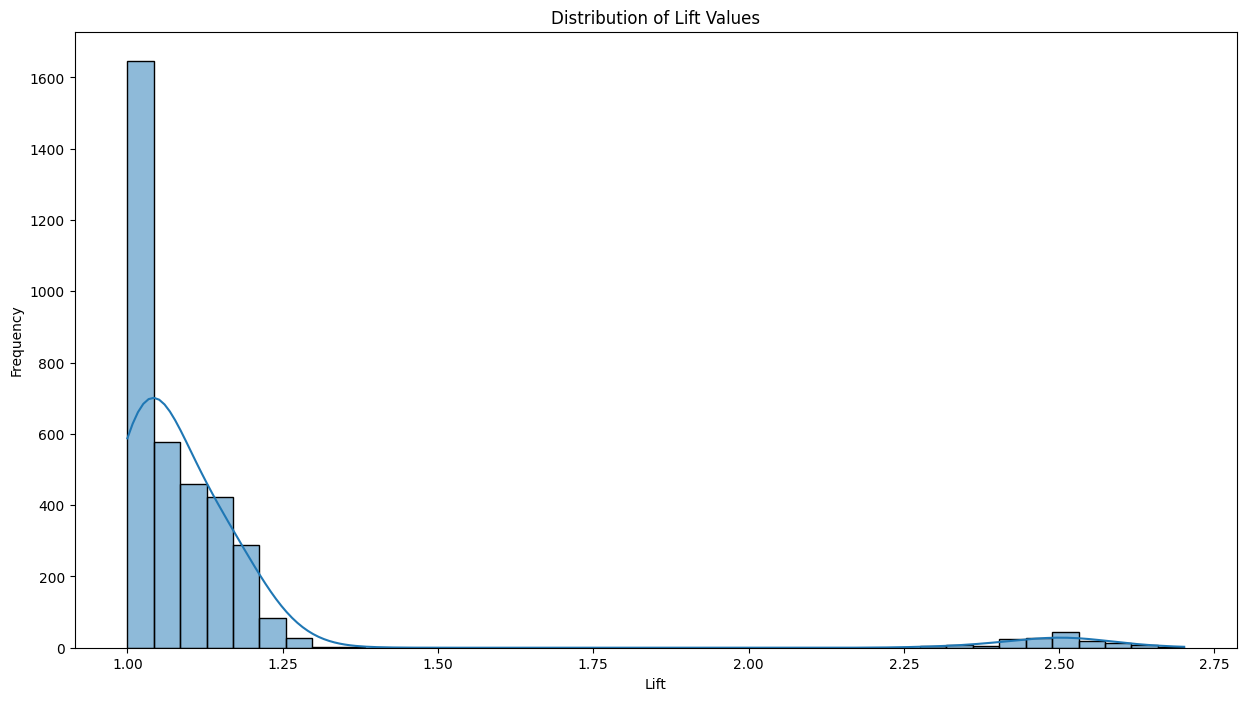

In [37]:
plt.figure(figsize=(15,8))
sns.histplot(rules['lift'], bins=40, kde=True)
plt.title('Distribution of Lift Values')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.show()

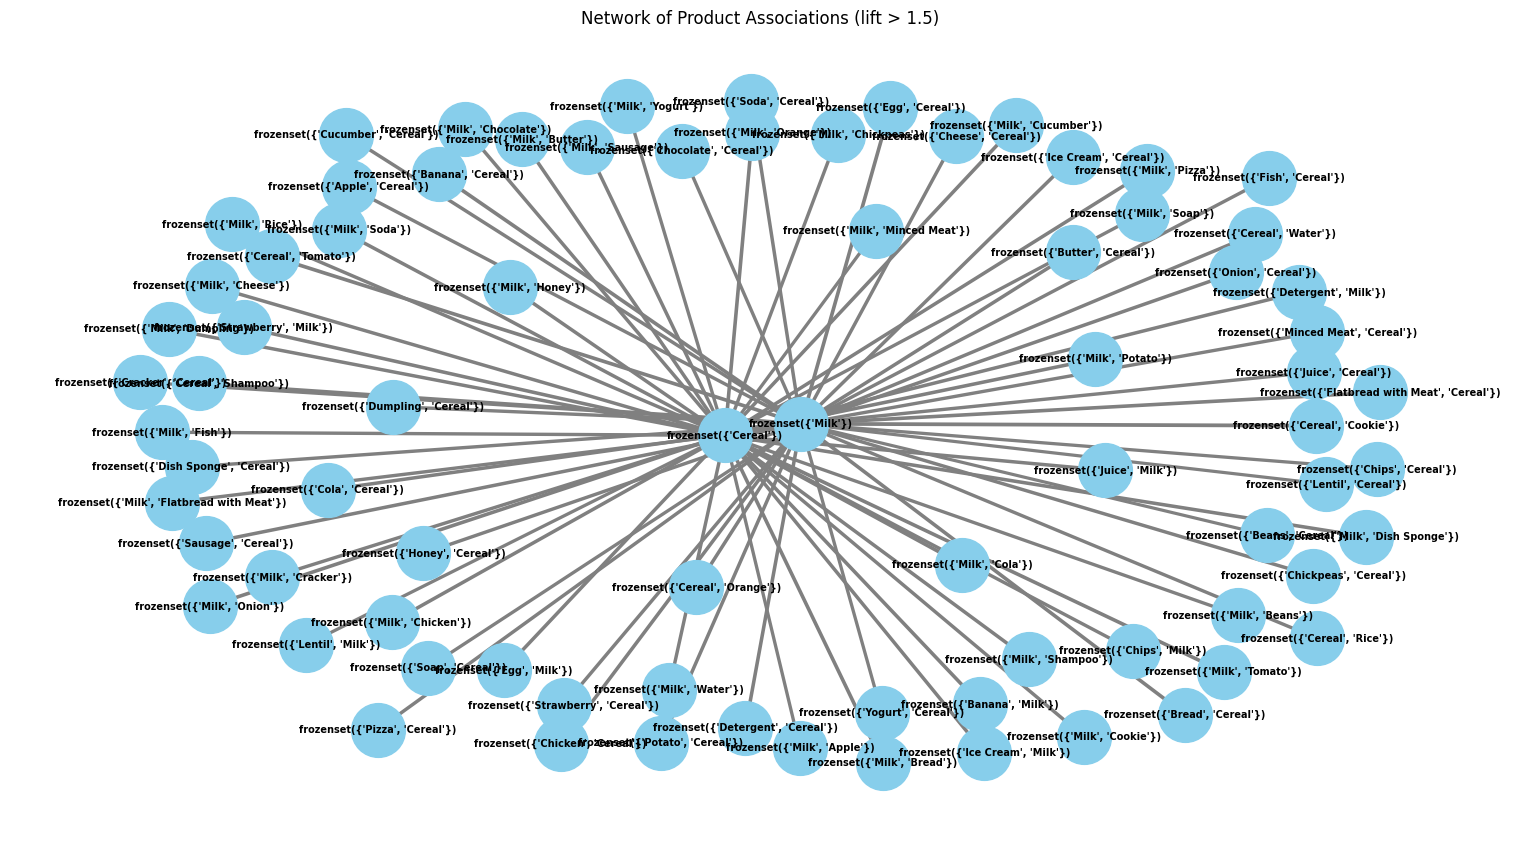

In [38]:
import networkx as nx

G = nx.from_pandas_edgelist(
    rules[rules['lift'] > 1.5],
    source='antecedents', target='consequents',
    edge_attr='lift'
)

plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G, k=0.5, iterations=20)
nx.draw(
    G, pos,
    with_labels=True,
    node_color='skyblue',
    node_size=1500,
    font_size=7,
    font_weight='bold',
    edge_color='gray',
    width=[d['lift'] for (_,_,d) in G.edges(data=True)]
)
plt.title('Network of Product Associations (lift > 1.5)')
plt.show()


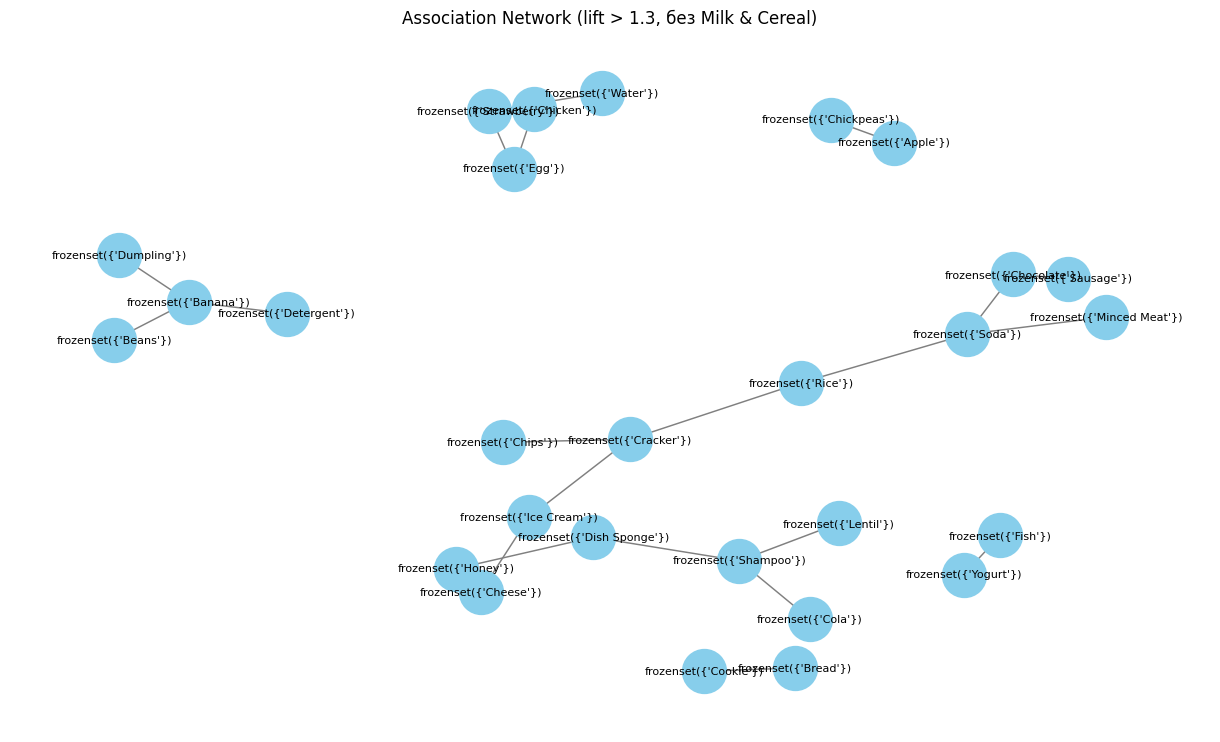

In [39]:
# фильтруем, чтобы убрать молоко и хлопья
popular = ['Milk', 'Cereal']
r = rules[
    (rules['lift'] > 1.05) &  # чуть мягче
    (rules['support'] > 0.01) &  # чтобы убрать случайные
    ~rules['antecedents'].apply(lambda x: any(i in popular for i in x)) &
    ~rules['consequents'].apply(lambda x: any(i in popular for i in x))
]

# строим граф
G = nx.from_pandas_edgelist(r, 'antecedents', 'consequents', edge_attr='lift')
pos = nx.spring_layout(G, k=0.4, seed=42)

# рисуем
plt.figure(figsize=(12, 7))
nx.draw(G, pos,
        with_labels=True,
        node_color='skyblue',
        node_size=1000,
        font_size=8,
        edge_color='gray',
        width=[d['lift'] for _,_,d in G.edges(data=True)])
plt.title('Association Network (lift > 1.3, без Milk & Cereal)')
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


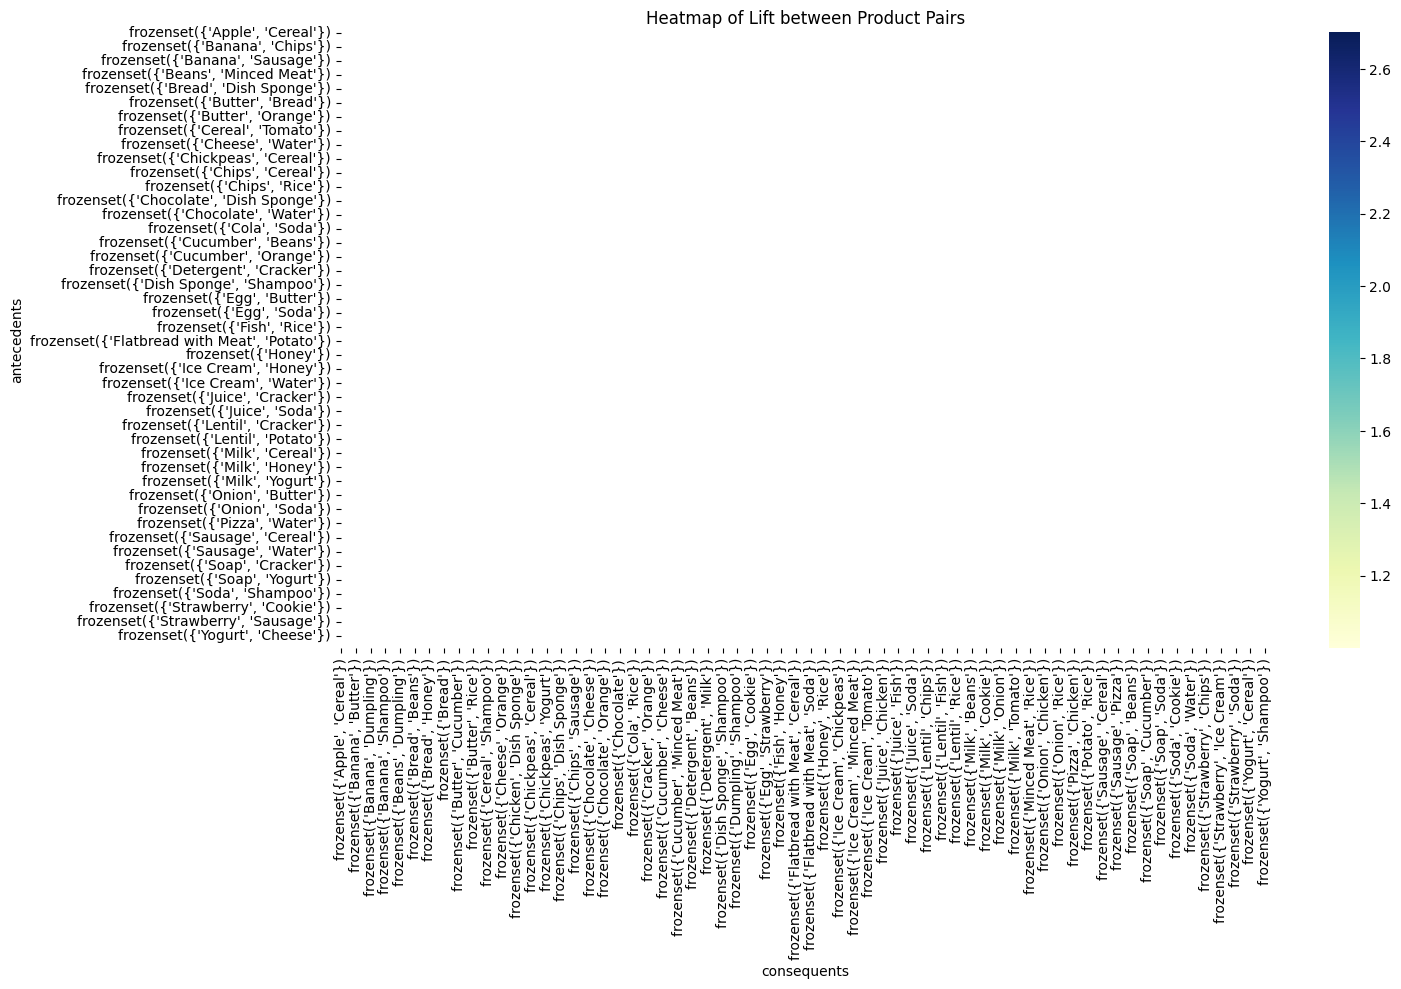

In [40]:
pivot = rules.pivot_table(
    values='lift',
    index=rules['antecedents'].astype(str),
    columns=rules['consequents'].astype(str)
)
plt.figure(figsize=(15,8))
sns.heatmap(pivot, cmap='YlGnBu', linewidths=0.1)
plt.title('Heatmap of Lift between Product Pairs')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


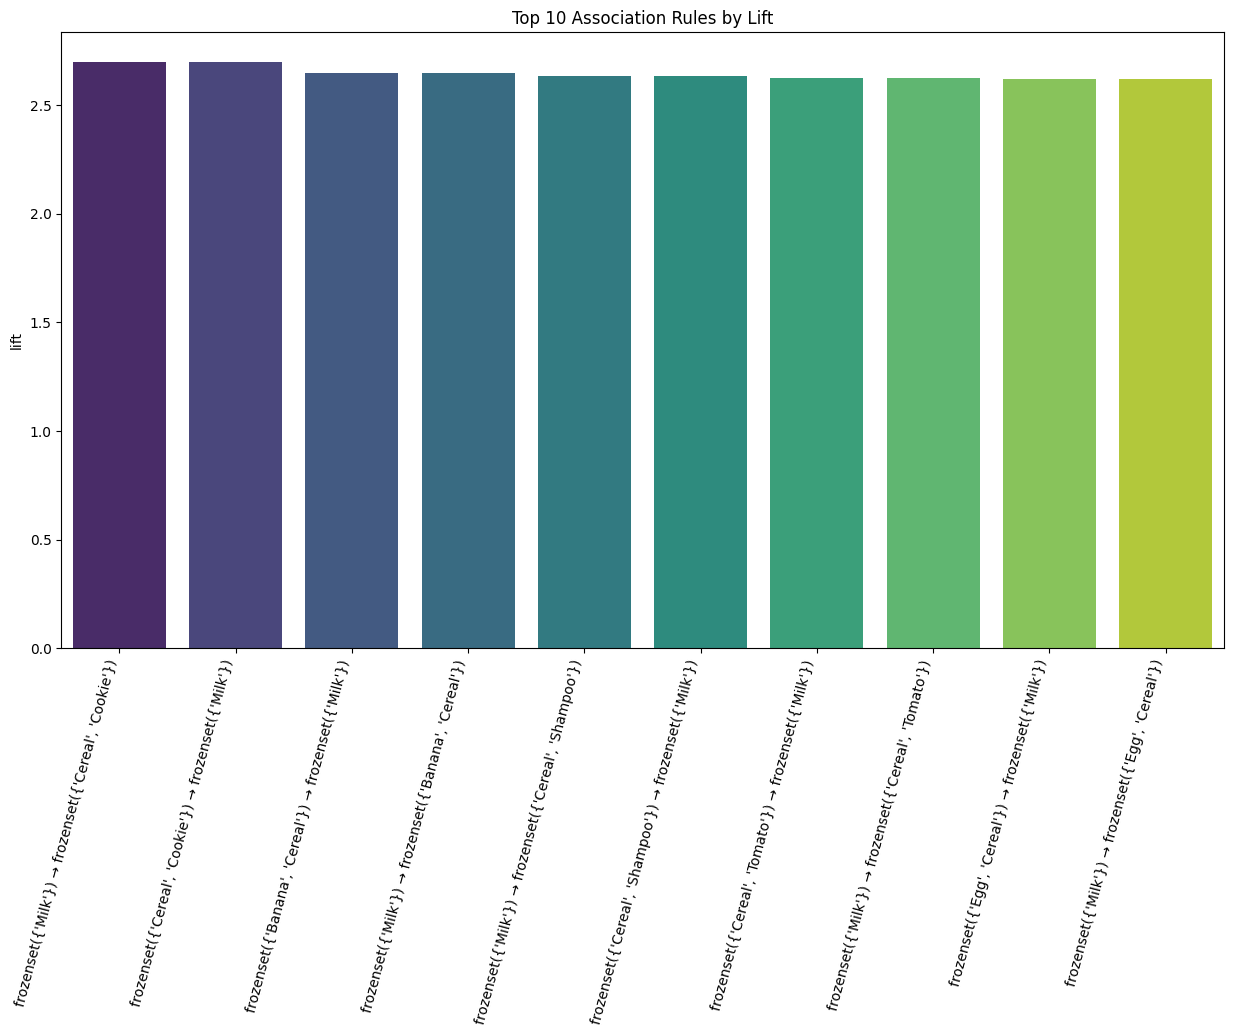

In [41]:
top_rules = rules.sort_values('lift', ascending=False).head(10)
plt.figure(figsize=(15,8))
sns.barplot(data=top_rules, y='lift',
            x=top_rules['antecedents'].astype(str) + ' → ' + top_rules['consequents'].astype(str),
            palette='viridis')
plt.xticks(rotation=75, ha='right')
plt.title('Top 10 Association Rules by Lift')
plt.show()

In [42]:
def recommend_products(purchased_items, rules, top_n=3, metric='lift'):
    # Преобразуем купленные товары в множество для удобства
    purchased_items = set(purchased_items)

    # Фильтруем правила, где antecedents полностью содержатся в покупках пользователя
    matched_rules = rules[rules['antecedents'].apply(lambda x: x.issubset(purchased_items))]

    if matched_rules.empty:
        return []

    # Разворачиваем consequents в список с весом по метрике
    recommendations = (
        matched_rules
        .explode('consequents')
        .groupby('consequents')[metric]
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
        .index.tolist()
    )

    # Убираем то, что уже куплено
    recommendations = [r for r in recommendations if r not in purchased_items]

    return recommendations

In [43]:
recommend_products(['Milk'], rules)

['Detergent', 'Chicken', 'Sausage']

In [44]:
unique_products

{'Apple',
 'Banana',
 'Beans',
 'Bread',
 'Butter',
 'Cereal',
 'Cheese',
 'Chicken',
 'Chickpeas',
 'Chips',
 'Chocolate',
 'Cola',
 'Cookie',
 'Cracker',
 'Cucumber',
 'Detergent',
 'Dish Sponge',
 'Dumpling',
 'Egg',
 'Fish',
 'Flatbread with Meat',
 'Honey',
 'Ice Cream',
 'Juice',
 'Lentil',
 'Milk',
 'Minced Meat',
 'Onion',
 'Orange',
 'Pizza',
 'Potato',
 'Rice',
 'Sausage',
 'Shampoo',
 'Soap',
 'Soda',
 'Strawberry',
 'Tomato',
 'Water',
 'Yogurt'}

In [45]:
def recommend_products_v2(purchased_items, rules, top_n=5, metric='lift'):
    """
    purchased_items: list or set of bought product names (strings)
    rules: DataFrame from association_rules (antecedents/consequents are frozenset-like)
    metric: primary metric for ranking ('lift' or 'confidence' or a custom combo)
    """
    purchased = set(purchased_items)

    # 1) Правила, где antecedents полностью содержатся в покупках (лучший кейс)
    exact_matches = rules[
        rules['antecedents'].apply(lambda a: set(a).issubset(purchased))
    ].copy()
    exact_matches['weight'] = 1.0

    # 2) Правила, где antecedents содержат хотя бы один из купленных товаров
    #    (полезно, если нет точных совпадений). Взвешиваем их по 1/len(antecedents)
    partial_matches = rules[
        rules['antecedents'].apply(lambda a: bool(set(a) & purchased) and not set(a).issubset(purchased))
    ].copy()
    partial_matches['weight'] = partial_matches['antecedents'].apply(lambda a: 1.0 / max(1, len(a)))

    # 3) Объединяем
    candidates = pd.concat([partial_matches, exact_matches], ignore_index=True)
    if candidates.empty:
        return []

    # 4) Разворачиваем consequents (каждый consequent отдельная строка)
    #    и считаем итоговую метрику: score = (metric) * weight * confidence (опционально)
    #    Чтобы учитывать и lift и confidence, можно умножать их (или использовать другое сочетание)
    candidates = candidates.explode('consequents').reset_index(drop=True)

    # Убедимся, что conseq — строка (если frozenset, берем элемент)
    # (в mlxtend consequents обычно frozenset({'Cereal'}) -> explode даёт 'Cereal')
    candidates['consequents'] = candidates['consequents'].apply(lambda x: next(iter(x)) if isinstance(x, (set, frozenset)) else x)

    # вычисляем скор — пример: lift * confidence * weight
    candidates['score'] = candidates['lift'] * candidates['confidence'] * candidates['weight']

    # 5) Группируем по consequent, берем максимум/среднее score, сортируем
    recs = (
        candidates
        .groupby('consequents')['score']
        .max()
        .sort_values(ascending=False)
    )

    # 6) Убираем уже купленные товары
    recs = [r for r in recs.index.tolist() if r not in purchased]

    return recs[:top_n]


In [46]:
recommend_products_v2(['Cola'], rules)

['Cereal', 'Milk', 'Shampoo', 'Cookie', 'Chicken']

In [47]:
def recommend_products_bidirectional(purchased_items, rules, top_n=5, metric='lift'):
    """
    Рекомендации с учётом обеих сторон правил: antecedents и consequents.
    
    purchased_items: list или set купленных товаров (строки)
    rules: DataFrame из association_rules (antecedents/consequents — frozenset)
    top_n: сколько рекомендаций вернуть
    metric: 'lift' или 'confidence' (для расчёта score)
    """
    purchased = set(purchased_items)
    
    if not purchased:
        return []

    candidates_list = []

    for _, row in rules.iterrows():
        antecedents = set(row['antecedents'])
        consequents = set(row['consequents'])

        # 1) Exact match по antecedents (все antecedents куплены)
        if antecedents.issubset(purchased):
            # кандидаты — consequents, weight = 1
            for c in consequents:
                if c not in purchased:
                    candidates_list.append({
                        'product': c,
                        'score': row['lift'] * row['confidence'] * 1.0
                    })

        # 2) Exact match по consequents (все consequents куплены)
        if consequents.issubset(purchased):
            # кандидаты — antecedents, weight = 0.7 (чуть меньше, чтобы не доминировало)
            for a in antecedents:
                if a not in purchased:
                    candidates_list.append({
                        'product': a,
                        'score': row['lift'] * row['confidence'] * 0.7
                    })

        # 3) Partial match по antecedents (хотя бы один куплен, но не все)
        if antecedents & purchased and not antecedents.issubset(purchased):
            weight = 1.0 / max(1, len(antecedents))
            for c in consequents:
                if c not in purchased:
                    candidates_list.append({
                        'product': c,
                        'score': row['lift'] * row['confidence'] * weight
                    })

        # 4) Partial match по consequents (хотя бы один куплен, но не все)
        if consequents & purchased and not consequents.issubset(purchased):
            weight = 0.7 / max(1, len(consequents))  # чуть меньше вес для обратки
            for a in antecedents:
                if a not in purchased:
                    candidates_list.append({
                        'product': a,
                        'score': row['lift'] * row['confidence'] * weight
                    })

    if not candidates_list:
        return []

    candidates_df = pd.DataFrame(candidates_list)

    # Группируем по продукту, берём максимум score
    recs = candidates_df.groupby('product')['score'].max().sort_values(ascending=False)

    return recs.index.tolist()[:top_n]


In [48]:
recommend_products_v2(['Beans'], rules)

['Cereal', 'Milk', 'Banana', 'Shampoo', 'Lentil']

In [49]:
recommend_products_bidirectional(['Beans'], rules)

['Cereal', 'Milk', 'Banana', 'Minced Meat', 'Cucumber']

In [50]:
def recommend_products_smart(purchased_items, rules, df_transactions, top_n=5):
    """
    Рекомендации с учётом обеих сторон правил и подавлением популярных товаров/комбинаций.

    purchased_items: list или set купленных товаров (строки)
    rules: DataFrame из association_rules (antecedents/consequents — frozenset)
    df_transactions: DataFrame с колонкой 'Product' (список покупок)
    top_n: сколько рекомендаций вернуть
    """
    purchased = set(purchased_items)
    
    if not purchased:
        return []

    # --- 1) Вычисляем популярность товаров ---
    all_products = list(chain.from_iterable(df['Product_list']))
    product_counts = Counter(all_products)
    total = len(all_products)
    product_popularity = {product: count / total for product, count in product_counts.items()} # частота 0-1

    # Задаём список явно популярных товаров для жесткой коррекции
    popular_items = {'Milk', 'Cereal', 'Yogurt'}

    candidates_list = []

    for _, row in rules.iterrows():
        antecedents = set(row['antecedents'])
        consequents = set(row['consequents'])

        # функция для скор с учетом популярности
        def calc_score(product, base_weight):
            # штраф по популярности
            pop_penalty = 1.0 - product_popularity.get(product, 0.0)
            # дополнительное снижение для супер популярных
            if product in popular_items:
                pop_penalty *= 0.3
            return row['lift'] * row['confidence'] * base_weight * pop_penalty

        # 1) Exact match antecedents
        if antecedents.issubset(purchased):
            weight = 1.0
            for c in consequents:
                if c not in purchased:
                    score = calc_score(c, weight)
                    candidates_list.append({'product': c, 'score': score})

        # 2) Exact match consequents
        if consequents.issubset(purchased):
            weight = 0.7
            for a in antecedents:
                if a not in purchased:
                    score = calc_score(a, weight)
                    candidates_list.append({'product': a, 'score': score})

        # 3) Partial match antecedents
        if antecedents & purchased and not antecedents.issubset(purchased):
            weight = 1.0 / max(1, len(antecedents))
            for c in consequents:
                if c not in purchased:
                    score = calc_score(c, weight)
                    candidates_list.append({'product': c, 'score': score})

        # 4) Partial match consequents
        if consequents & purchased and not consequents.issubset(purchased):
            weight = 0.7 / max(1, len(consequents))
            for a in antecedents:
                if a not in purchased:
                    score = calc_score(a, weight)
                    candidates_list.append({'product': a, 'score': score})

        # 5) Умное снижение для комбинаций популярных товаров
        if (antecedents & popular_items) and (consequents & popular_items):
            for a in antecedents:
                for c in consequents:
                    # если уже добавлены — снижаем score
                    for candidate in candidates_list:
                        if candidate['product'] == a or candidate['product'] == c:
                            candidate['score'] *= 0.2

    if not candidates_list:
        return []

    candidates_df = pd.DataFrame(candidates_list)

    # Группируем по продукту, берём максимум score
    recs = candidates_df.groupby('product')['score'].max().sort_values(ascending=False)

    return recs.index.tolist()[:top_n]


In [51]:
def recommend_products_adaptive(purchased_items, rules, df_transactions, top_n=5, alpha=2.0):
    """
    Двусторонние рекомендации с адаптивным весом по популярности.
    
    purchased_items: list или set купленных товаров (строки)
    rules: DataFrame из association_rules (antecedents/consequents — frozenset)
    df_transactions: DataFrame с колонкой 'Product_list' (список продуктов в каждой транзакции)
    top_n: сколько рекомендаций вернуть
    alpha: сила коррекции популярности (чем больше, тем сильнее штраф для популярных товаров)
    """
    purchased = set(purchased_items)
    if not purchased:
        return []

    # --- 1) Вычисляем частоты всех товаров ---
    all_products = list(chain.from_iterable(df['Product_list']))
    total = len(all_products)
    product_counts = Counter(all_products)
    product_freq = {p: c / total for p, c in product_counts.items()}  # freq 0-1

    # --- 2) Функция адаптивного веса по популярности ---
    def popularity_weight(product):
        freq = product_freq.get(product, 0)
        return 1 / (1 + alpha * freq)  # популярные товары получают меньший вес, редкие — больше

    candidates_list = []

    for _, row in rules.iterrows():
        antecedents = set(row['antecedents'])
        consequents = set(row['consequents'])

        # Расчёт score с адаптивным весом
        def calc_score(product, base_weight):
            return row['lift'] * row['confidence'] * base_weight * popularity_weight(product)

        # --- Exact match antecedents ---
        if antecedents.issubset(purchased):
            for c in consequents:
                if c not in purchased:
                    candidates_list.append({'product': c, 'score': calc_score(c, 1.0)})

        # --- Exact match consequents ---
        if consequents.issubset(purchased):
            for a in antecedents:
                if a not in purchased:
                    candidates_list.append({'product': a, 'score': calc_score(a, 0.7)})

        # --- Partial match antecedents ---
        if antecedents & purchased and not antecedents.issubset(purchased):
            weight = 1.0 / max(1, len(antecedents))
            for c in consequents:
                if c not in purchased:
                    candidates_list.append({'product': c, 'score': calc_score(c, weight)})

        # --- Partial match consequents ---
        if consequents & purchased and not consequents.issubset(purchased):
            weight = 0.7 / max(1, len(consequents))
            for a in antecedents:
                if a not in purchased:
                    candidates_list.append({'product': a, 'score': calc_score(a, weight)})

    if not candidates_list:
        return []

    candidates_df = pd.DataFrame(candidates_list)

    # Группируем по продукту, берём максимум score
    recs = candidates_df.groupby('product')['score'].max().sort_values(ascending=False)

    return recs.index.tolist()[:top_n]

In [52]:
recommend_products_v2(['Cereal', 'Milk'], rules)

['Cookie', 'Tomato', 'Banana', 'Shampoo', 'Bread']

In [53]:
recommend_products_bidirectional(['Cereal', 'Milk'], rules)

['Bread', 'Tomato', 'Orange', 'Onion', 'Banana']

In [54]:
recommend_products_smart(['Cereal', 'Milk'], rules, basket_df)

['Chips', 'Cola', 'Beans', 'Apple', 'Onion']

In [55]:
recommend_products_adaptive(['Cereal', 'Milk'], rules, basket_df)

['Bread', 'Tomato', 'Orange', 'Onion', 'Banana']

# Метрики

In [56]:
unique_products

{'Apple',
 'Banana',
 'Beans',
 'Bread',
 'Butter',
 'Cereal',
 'Cheese',
 'Chicken',
 'Chickpeas',
 'Chips',
 'Chocolate',
 'Cola',
 'Cookie',
 'Cracker',
 'Cucumber',
 'Detergent',
 'Dish Sponge',
 'Dumpling',
 'Egg',
 'Fish',
 'Flatbread with Meat',
 'Honey',
 'Ice Cream',
 'Juice',
 'Lentil',
 'Milk',
 'Minced Meat',
 'Onion',
 'Orange',
 'Pizza',
 'Potato',
 'Rice',
 'Sausage',
 'Shampoo',
 'Soap',
 'Soda',
 'Strawberry',
 'Tomato',
 'Water',
 'Yogurt'}

In [57]:
all_recommendations = []

for product in unique_products: 
    recs = recommend_products_bidirectional([product], rules)
    all_recommendations.extend(recs)

unique_recs = set(all_recommendations)
coverage = len(unique_recs) / len(unique_products)

print(f"Coverage: {coverage:.2%}")
print(f"Уникальных рекомендованных товаров: {len(unique_recs)} из {len(unique_products)}")

Coverage: 92.50%
Уникальных рекомендованных товаров: 37 из 40


In [58]:
all_recommendations = []

for product in unique_products: 
    recs = recommend_products_v2([product], rules)
    all_recommendations.extend(recs)

unique_recs = set(all_recommendations)
coverage = len(unique_recs) / len(unique_products)

print(f"Coverage: {coverage:.2%}")
print(f"Уникальных рекомендованных товаров: {len(unique_recs)} из {len(unique_products)}")

Coverage: 90.00%
Уникальных рекомендованных товаров: 36 из 40


In [59]:
all_recommendations = []

for product in unique_products: 
    recs = recommend_products_smart([product], rules, basket_df)
    all_recommendations.extend(recs)

unique_recs = set(all_recommendations)
coverage = len(unique_recs) / len(unique_products)

print(f"Coverage: {coverage:.2%}")
print(f"Уникальных рекомендованных товаров: {len(unique_recs)} из {len(unique_products)}")

Coverage: 95.00%
Уникальных рекомендованных товаров: 38 из 40


In [60]:
all_recommendations = []

for product in unique_products: 
    recs = recommend_products_adaptive([product], rules, basket_df)
    all_recommendations.extend(recs)

unique_recs = set(all_recommendations)
coverage = len(unique_recs) / len(unique_products)

print(f"Coverage: {coverage:.2%}")
print(f"Уникальных рекомендованных товаров: {len(unique_recs)} из {len(unique_products)}")

Coverage: 95.00%
Уникальных рекомендованных товаров: 38 из 40
